This notebook uses Exponential Smoothing to forecast a time series.

### Imports

In [25]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import itertools
from itertools import cycle


### Exploration Functions

In [26]:
def plot_time_series(df, column, title=None):
    """
    Plot a time series from any dataframe and column.

    Parameters:
    df : pd.DataFrame with a datetime index
    column : str, column name to plot
    title : str, optional, plot title
    """
    
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df[column], marker='o', linestyle='-', label=column)
    plt.title(title if title else f"{column} Over Time")
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.grid(True)
    plt.legend()
    plt.show()


def graph_monthly(df, column):
    """
    Plot monthly averages per year for any dataframe and column.

    Parameters:
    df : pd.DataFrame with a datetime index
    column : str, column name to plot
    """
    
    # Group by month and year
    monthly_data = df[column].groupby([df.index.year, df.index.month]).mean().unstack(level=0)

    # Plot each year
    plt.figure(figsize=(12,6))
    for year in monthly_data.columns:
        plt.plot(monthly_data.index, monthly_data[year], marker='o', label=str(year))

    plt.title(f"Monthly {column} per Year")
    plt.xlabel("Month")
    plt.ylabel(column)
    plt.xticks(range(1,13))
    plt.grid(True)
    plt.legend(title="Year")
    plt.show()


def graph_boxplot(df, column):
    """
    Plot yearly boxplots showing monthly distribution for any dataframe and column.

    Parameters:
    df : pd.DataFrame with a datetime index
    column : str, column name to plot
    """

    df_box = df.copy()
    df_box['Year'] = df_box.index.year
    df_box['Month'] = df_box.index.month

    # Prepare data for boxplot
    data_to_plot = [df_box[df_box['Year'] == year][column] for year in sorted(df_box['Year'].unique())]

    plt.figure(figsize=(12,6))
    plt.boxplot(data_to_plot, labels=sorted(df_box['Year'].unique()))
    plt.title(f"Monthly {column} Distribution per Year")
    plt.xlabel("Year")
    plt.ylabel(column)
    plt.grid(True)
    plt.show()


def plot_seasonal_decompose(df, column, model='multiplicative', period=12):
    """
    Decompose a time series and plot its trend, seasonal, and residual components.

    Parameters:
    df : pd.DataFrame with a datetime index
    column : str, column name to decompose
    model : str, 'additive' or 'multiplicative' (default: 'multiplicative')
    period : int, seasonal period (default: 12)
    """
    
    decomp = seasonal_decompose(df[column], model=model, period=period)
    decomp.plot()
    # plt.suptitle(f"{model.capitalize()} Decomposition", fontsize=16)
    plt.show()


### Modeling Functions

#### Notes

We will use MAPE over RMSE because it provides a relative measure of error that's easy to interpret. By expressing errors as a percentage of actual values, MAPE is scale independent and gives a intuitive sense of how far off forecasts are. MAPE also treats all periods more evenly, while RMSE gives extra weight to large errors  which can skew evaluation to outliers.

The `Damped` option in the function `ExponentialSmoothing`, when true applies a damping factor  0 < $\phi$ < 1 to the trend.

With damping:
- The trend contribution flattens over time.
- This prevents the forecast from growing too fast or declining too fast , which is more realistic.

#### Functions

In [27]:

# Evaluation metric

def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return rmse, mape


# Holt-Winters Grid Search

def holt_winters_grid_search(data, 
                             forecast_ahead=24,
                             trends=[None, "add", "mul"],
                             seasonals=[None, "add", "mul"],
                             damped_opts=[False, True],
                             seasonal_periods=[None, 6, 12, 24]):
    """
    Perform grid search over Holt-Winters parameters.
    """
    split_idx = int(len(data) * 0.9)
    train, test = data.iloc[:split_idx], data.iloc[split_idx:]
    forecast_horizon = len(test)

    results = []
    best_models = {}

    for trend, seasonal, damped, sp in itertools.product(trends, seasonals, damped_opts, seasonal_periods):
        if seasonal is None and sp is not None:
            continue
        if seasonal is not None and sp is None:
            continue
        try:
            model = ExponentialSmoothing(
                train,
                trend=trend,
                seasonal=seasonal,
                damped_trend=damped,
                seasonal_periods=sp,
                initialization_method='estimated'
            )
            fit = model.fit(optimized=True)
            pred = fit.forecast(forecast_horizon)
            rmse, mape = evaluate(test, pred)
            results.append({
                "Trend": trend,
                "Seasonal": seasonal,
                "Damped": damped,
                "Seasonal_Periods": sp,
                "RMSE": rmse,
                "MAPE": mape
            })
            best_models[(trend, seasonal, damped, sp)] = fit
        except ValueError:
            continue

    results_df = pd.DataFrame(results)
    results_df["RMSE"] = results_df["RMSE"].round(2)
    results_df["MAPE"] = (results_df["MAPE"]*100).round(2)
    results_df = results_df.sort_values("MAPE").reset_index(drop=True)

    return results_df, best_models, train, test


# Extract top forecasts & parameters

def holt_winters_top_models(results_df, best_models, train, test, top_n=3, forecast_ahead=24):
    top_models = results_df.head(top_n)
    future_forecasts = {}
    top_params = {}
    last_test_date = test.index[-1]
    holt_dates = pd.date_range(last_test_date + pd.offsets.MonthBegin(), periods=forecast_ahead, freq="M")

    for _, row in top_models.iterrows():
        sp = None if pd.isna(row["Seasonal_Periods"]) else row["Seasonal_Periods"]
        key = (row["Trend"], row["Seasonal"], row["Damped"], sp)
        fit = best_models[key]

        full_forecast = fit.forecast(len(test) + forecast_ahead)
        future_forecasts[key] = full_forecast[-forecast_ahead:]
        top_params[key] = fit.params

    return future_forecasts, top_params, holt_dates


# Extract key parameters as table

def holt_winters_params_table(top_params, key_params=None):
    if key_params is None:
        key_params = ["smoothing_level", "smoothing_trend", "smoothing_seasonal", "damping_trend"]
    
    rows = []
    for k, p in top_params.items():
        row = {"Model": str(k)}
        for param in key_params:
            val = p.get(param, None)
            if val is None or (isinstance(val, float) and np.isnan(val)):
                row[param] = np.nan
            else:
                row[param] = val
        rows.append(row)
    
    df = pd.DataFrame(rows)
    df = df.set_index("Model")
    df = df.round(4)
    return df


In [28]:
# Plot top Holt-Winters forecasts

def plot_forecasts(data, test, results_df, future_forecasts, dates, top_n=3, start_plot=None, y_label="Value"):
    """
    Plot observed series and top Holt-Winters forecasts, anchored to the last test value.
    Assumes forecast keys in future_forecasts exactly match the parameter tuples in results_df.
    """
    plt.figure(figsize=(12, 6))

    # Filter observed data if requested
    if start_plot is not None:
        plot_data = data[data.index >= pd.to_datetime(start_plot)]
    else:
        plot_data = data
    plt.plot(plot_data.index, plot_data.values, 'o-', label="Observed (Train + Test)")

    colors = cycle(["r", "g", "b", "m", "c", "y"])
    top_models = results_df.head(top_n)

    for (_, row), color in zip(top_models.iterrows(), colors):
        # Build the parameter key
        sp = None if pd.isna(row["Seasonal_Periods"]) else row["Seasonal_Periods"]
        key = (row["Trend"], row["Seasonal"], row["Damped"], sp)

        forecast_vals = np.asarray(future_forecasts[key]).ravel()
        forecast_series = pd.Series(forecast_vals, index=dates)

        # --- Anchor forecast to last test value ---
        last_test_idx = test.index[-1]
        last_test_val = test.iloc[-1]

        if last_test_idx < dates[0]:
            # Prepend last test value if forecasts start after test
            joined_index = pd.Index([last_test_idx]).append(dates)
            joined_vals = np.concatenate([[last_test_val], forecast_series.values])
        else:
            # Overwrite the first forecast point with last test value
            joined_index = dates
            joined_vals = forecast_series.values.copy()
            joined_vals[0] = last_test_val

        joined_forecast = pd.Series(joined_vals, index=joined_index)

        # Label
        label = (
            f"Trend={row['Trend']}, Seasonal={row['Seasonal']}, "
            f"Damped={row['Damped']}, sp={sp}, "
            f"RMSE={row['RMSE']:.2f}, MAPE={row['MAPE']:.2f}%"
        )
        plt.plot(joined_forecast.index, joined_forecast.values,
                 linestyle="--", color=color, label=label)

    # Train/Test split line
    split_line = test.index[0]
    if start_plot is None or split_line >= pd.to_datetime(start_plot):
        plt.axvline(split_line, color='k', linestyle='--', alpha=0.6, label="Train/Test split")

    plt.title(f"Top {top_n} Holt-Winters Forecasts ({len(dates)} Periods Ahead)")
    plt.xlabel("Date")
    plt.ylabel(y_label)
    plt.legend(fontsize=9)
    plt.grid(True)

    x_start = pd.to_datetime(start_plot) if start_plot is not None else data.index[0]
    plt.xlim(x_start, dates[-1])
    plt.show()


In [29]:
# Plot Holt-Winters forecast with 95% prediction interval

def plot_forecast_with_interval(data, test, results_df, future_forecasts, dates, start_plot=None, y_label="Value"):
    """
    Plot observed data, the best Holt-Winters forecast, and a simple 95% prediction interval.
    """

    # --- Observed series ---
    plt.figure(figsize=(12, 6))
    plot_data = data if start_plot is None else data[data.index >= pd.to_datetime(start_plot)]
    plt.plot(plot_data.index, plot_data.values, 'o-', label="Observed")

    # --- Best model from grid search ---
    row = results_df.iloc[0]
    trend = None if pd.isna(row["Trend"]) else row["Trend"]
    seasonal = None if pd.isna(row["Seasonal"]) else row["Seasonal"]
    damped = bool(row["Damped"])
    sp = None if pd.isna(row["Seasonal_Periods"]) else int(row["Seasonal_Periods"])

    key = (trend, seasonal, damped, sp)
    forecast = np.asarray(future_forecasts[key])[:len(dates)]  # align to horizon
    forecast_series = pd.Series(forecast, index=dates)

    # --- Anchor forecast to last test value for continuity ---
    joined_forecast = pd.concat([
        pd.Series([test.iloc[-1]], index=[test.index[-1]]),
        forecast_series
    ])

    # --- Refit model on training set to get residuals ---
    train = data.iloc[:len(data) - len(test)]
    fitted = ExponentialSmoothing(
        train, trend=trend, seasonal=seasonal,
        seasonal_periods=sp, damped_trend=damped
    ).fit(optimized=True)

    resid_std = (train - fitted.fittedvalues).std()
    z = 1.96 # 95% CI
    lower = forecast_series - z * resid_std
    upper = forecast_series + z * resid_std

    # --- Plot forecast and interval ---
    plt.plot(joined_forecast.index, joined_forecast.values, "--r", label="Forecast")
    plt.fill_between(dates, lower, upper, color="r", alpha=0.2, label="95% PI")

    # --- Train/Test split marker ---
    split_line = test.index[0]
    if start_plot is None or split_line >= pd.to_datetime(start_plot):
        plt.axvline(split_line, color="k", linestyle="--", alpha=0.6, label="Train/Test split")

    # --- Labels ---
    plt.title(f"Holt-Winters Forecast with 95% PI ({len(dates)} steps ahead)")
    plt.xlabel("Date")
    plt.ylabel(y_label)
    plt.legend(fontsize=9)
    plt.grid(True)
    plt.xlim(pd.to_datetime(start_plot) if start_plot else data.index[0], dates[-1])
    plt.show()


### 🔑 Core Concept

* A **prediction interval (PI)** gives a range where we expect future observations to fall, accounting for both model uncertainty and random noise.
* In your code, it’s a **95% PI** constructed as:

  $$
  \text{Forecast} \pm 1.96 \times \text{residual standard deviation}
  $$

---

### 📌 Points to Emphasize

1. **Interpretation of 95%**

   * About 95% of future values should fall within the interval if model assumptions (e.g., normality of residuals) hold.
   * It’s not a guarantee — 5% of points will naturally lie outside.

2. **How the interval is built in your code**

   * Residuals from the training fit measure typical forecast error.
   * Their standard deviation (`resid_std`) is used as a constant error bound.
   * The z-score of 1.96 comes from the standard normal distribution (central 95%).

3. **Simplifying assumption**

   * The interval is **flat** across horizons because it uses a single residual standard deviation.
   * This is an approximation — in reality, forecast error grows with horizon length.

4. **Strengths of this approach**

   * Quick, interpretable, and easy to implement.
   * Gives stakeholders a sense of uncertainty rather than just a line forecast.
   * Works as a first approximation when exact error distribution is complex.

5. **Limitations**

   * Ignores error accumulation in longer-horizon forecasts.
   * Assumes residuals are iid and approximately normal.
   * Doesn’t reflect possible model misspecification or parameter uncertainty.
   * Actual coverage (percentage of points within interval) may be less than 95%.

6. **Alternatives / More Robust Approaches**

   * Bootstrapping residuals or simulating future paths to build empirical intervals.
   * Using analytic formulas for error propagation (ARIMA has this built in; Holt-Winters does not).
   * Bayesian forecasting, which naturally produces uncertainty estimates.

---

👉 **Soundbite for an interview:**
*A 95% prediction interval communicates forecast uncertainty by showing where future data is likely to fall. In our implementation, it’s built from residual variation and a 1.96 z-score, which is simple and intuitive but assumes constant error variance. In practice, errors grow with horizon, so more advanced methods like bootstrapping or simulation can give better intervals.*

The **confidence / prediction interval** in your function is built in a fairly simple way. Here’s what’s happening step by step:

1. **Fit Holt-Winters to the training data**

   ```python
   fitted = ExponentialSmoothing(...).fit(optimized=True)
   ```

   This gives fitted values for the training set.

2. **Estimate the model’s residual variance**

   ```python
   resid_std = (train - fitted.fittedvalues).std()
   ```

   This computes the standard deviation of the one-step-ahead in-sample errors.

   * Idea: the residuals reflect the typical forecast error magnitude.
   * Assumption: these errors are approximately independent and normally distributed with mean zero.

3. **Set the z-score for the confidence level**

   ```python
   z = 1.96  # corresponds to 95% interval under normality
   ```

   * 1.96 is the cutoff for the middle 95% of a standard normal distribution.

4. **Build upper and lower bounds around the forecast**

   ```python
   lower = forecast_series - z * resid_std
   upper = forecast_series + z * resid_std
   ```

   * Each forecasted point is given the same constant margin of error.
   * The interval widens or narrows depending only on the residual spread, **not on forecast horizon**.

5. **Plot the interval**

   ```python
   plt.fill_between(dates, lower, upper, color="r", alpha=0.2)
   ```

   Visually shows the range in which \~95% of future observations are expected to fall if the assumptions hold.

---

⚠️ **Important caveats**

* This is a *naïve interval*: it assumes forecast error variance is constant at all horizons. In reality, uncertainty grows as you forecast further ahead.
* A proper prediction interval would propagate the model’s error structure through the forecast horizon.
* Still, this method is useful as a quick, interpretable bound when exact forecast error distribution is hard to compute.

Questions:

Why is 1.96 the “95% z-score”?

* The **z-score** is the number of standard deviations away from the mean in a standard normal distribution $N(0,1)$.
* For a 95% interval, we want the central 95% of the probability mass. That leaves 5% in the tails, split as 2.5% in each tail.
* Mathematically:

$$
P(-z \leq Z \leq z) = 0.95 \quad \text{where } Z \sim N(0,1)
$$

* Solving gives $z = 1.96$.

  * $\Phi(1.96) \approx 0.975$, meaning 97.5% of the probability is below +1.96.
  * Symmetry gives 2.5% below −1.96.
  * Together: $0.975 - 0.025 = 0.95$.

That’s why ±1.96 standard deviations covers 95% of outcomes under the normal distribution.

---

Is `resid_std` a constant?

In your code:

```python
resid_std = (train - fitted.fittedvalues).std()
```

* This computes **one single number**: the sample standard deviation of the in-sample residuals.
* Once calculated, it’s treated as a **constant margin of error** for all future forecast points.
* In reality, the variance of forecast errors usually **increases with horizon length** (the further ahead you forecast, the more uncertainty accumulates).

So:

* In your current implementation, `resid_std` is constant.
* In reality, forecast uncertainty is horizon-dependent, so a “proper” prediction interval would have widening bands as you move into the future.

### Time Series 1

Time Series 1:
This time series corresponds to a fictionalised number of customers on a Generation tariff each month.


In [30]:
df = pd.read_excel(
    'Assessment exercise.xlsx',
    sheet_name='Time Series 1',
    usecols=['Date', 'Customer Count']
)

# Ensure Date is datetime and set index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
data = df['Customer Count']


In [31]:
# df.head(5) # 2018-04-01	
# df.tail(5) # 2025-07-01	

#### Exploration

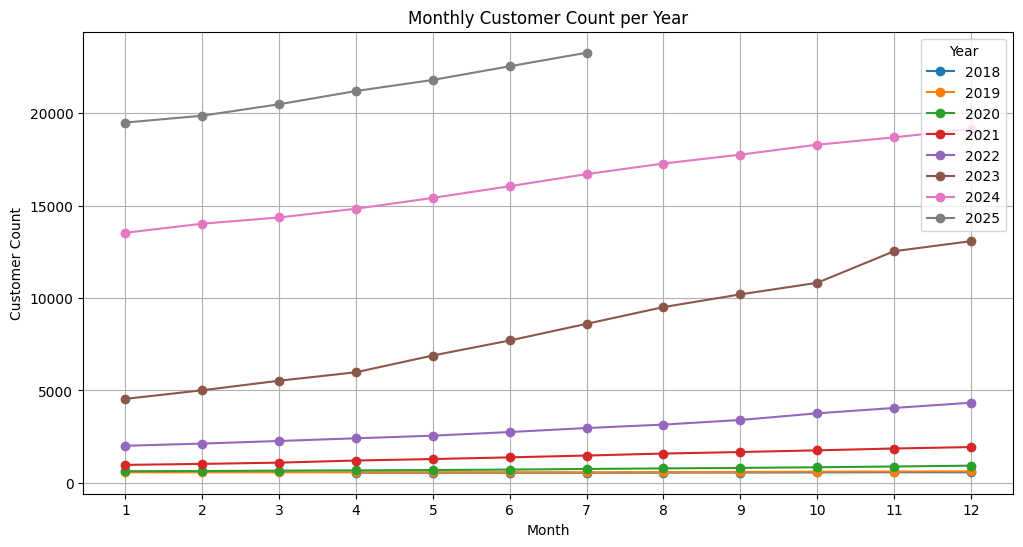

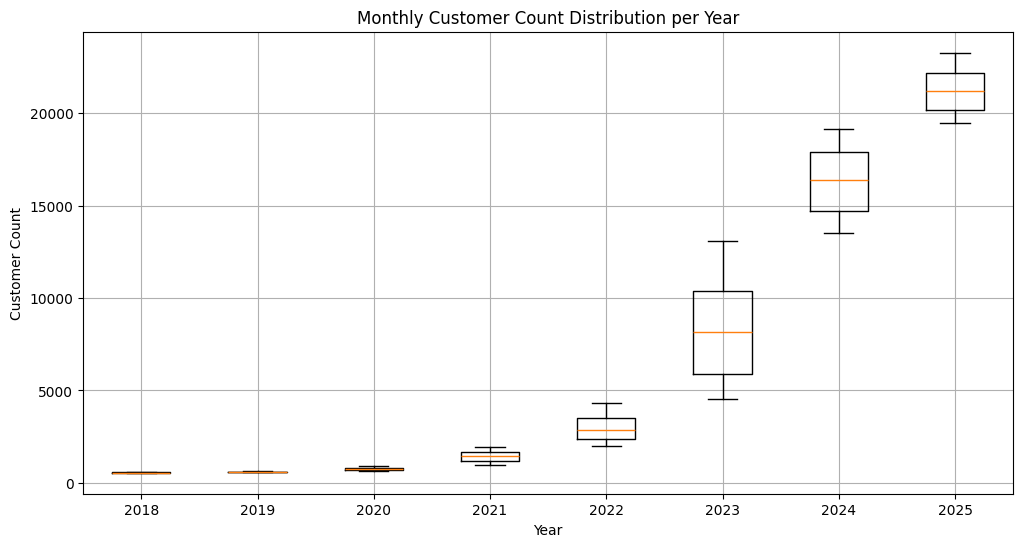

In [32]:
# plot_time_series(df, 'Customer Count')
graph_monthly(df, 'Customer Count')
graph_boxplot(df, 'Customer Count')
# plot_seasonal_decompose(df,'Customer Count', model='multiplicative', period=12)
# plot_seasonal_decompose(df,'Customer Count', model='additive', period=12)

#### Exponential Smoothing

In [33]:
# Train/Test split

split_idx = int(len(data) * 0.9)
train, test = data.iloc[:split_idx], data.iloc[split_idx:]

In [34]:
# Grid search
results_df, best_models, train, test = holt_winters_grid_search(data)

# Top forecasts & parameters
future_forecasts, top_params, dates = holt_winters_top_models(results_df, best_models, train, test)

top_params_df = holt_winters_params_table(top_params)

In [11]:
# results_df.sort_values(by="RMSE", ascending=True).head(3)

In [35]:
results_df.sort_values(by="MAPE", ascending=True).head(3)

,Trend,Seasonal,Damped,Seasonal_Periods,RMSE,MAPE
0,add,None,True,NaN,313.90,1.35
1,add,add,False,12.0,314.35,1.38
2,add,add,True,12.0,314.01,1.39


In [36]:
top_params_df.head()

,smoothing_level,smoothing_trend,smoothing_seasonal,damping_trend
Model,,,,
"('add', None, True, None)",0.9470,0.4479,NaN,0.9946
"('add', 'add', False, 12.0)",0.8965,0.5115,0.0,NaN
"('add', 'add', True, 12.0)",1.0000,0.4273,0.0,0.9950


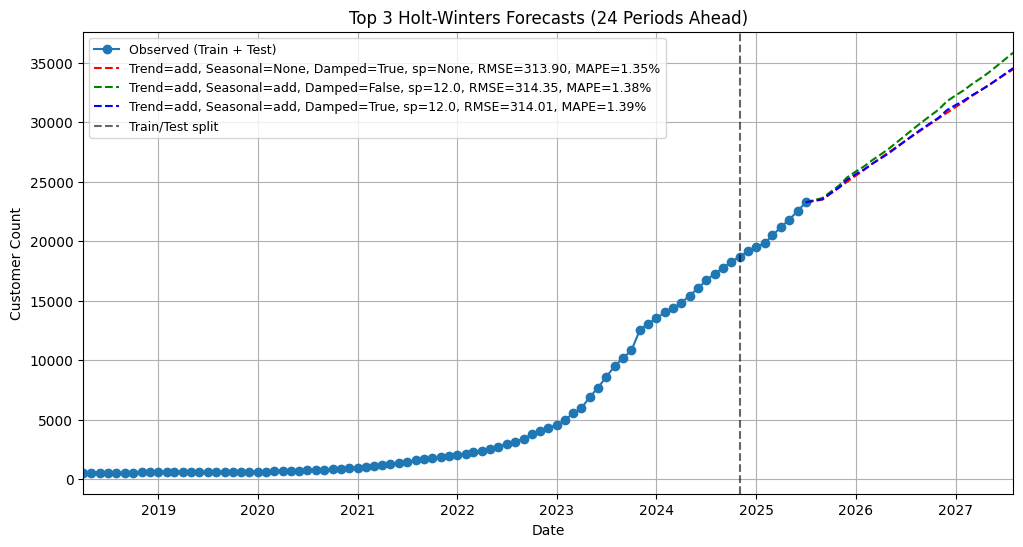

In [37]:
# Plot top 3 forecasts
plot_forecasts(
    data,
    test,
    results_df,
    future_forecasts,
    dates,
    top_n=3,
    y_label="Customer Count"
)

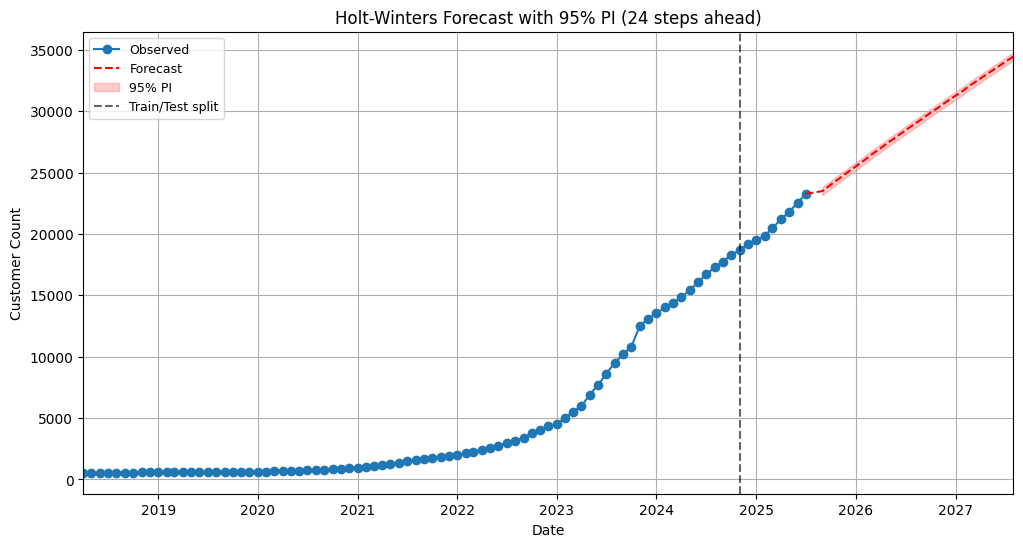

In [39]:
plot_forecast_with_interval(
    data,
    test,
    results_df,
    future_forecasts,
    dates,
    y_label="Customer Count"
)

The forecast shows that customer numbers have been fairly flat until around 2020, but then growth picked up, accelerating sharply from 2022 onwards. By the end of 2024, the data already shows over 20000 customers, which is a huge jump compared to the earlier years.

The model takes that recent trend and projects it forward. It suggests that growth will continue steadily, reaching around 35000 customers by 2027. The shaded area shows the 95% prediction interval, which we expect to widen as we get further out into the future.

In the short term, this looks like a reasonable forecast. The model has tracked the historical data closely, and it makes sense to expect continued growth into 2025 and 2026. Where we need to be cautious is further out. Holt-Winters is good at handling trends and seasonality, but it doesn’t know about real-world limits like market saturation. Growth like this can’t continue forever, so the straight-line trend the model projects is probably too optimistic over the long run.

The forecast is useful for showing that strong growth is likely to continue in the near future, but for longer-term planning it would be wise to consider models that account for natual flattening such as logistic or Gompertz curves.

### Time Series 2

In [40]:
df = pd.read_excel(
    'Assessment exercise.xlsx',
    sheet_name='Time Series 2',
    usecols=['Date', 'GWh']
)

# Ensure Date is datetime and set index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
data = df['GWh']


In [41]:
# df.head(3) # start date: 2018-04-01	
# df.tail(3) # end date: 2025-07-01	

#### Exploration

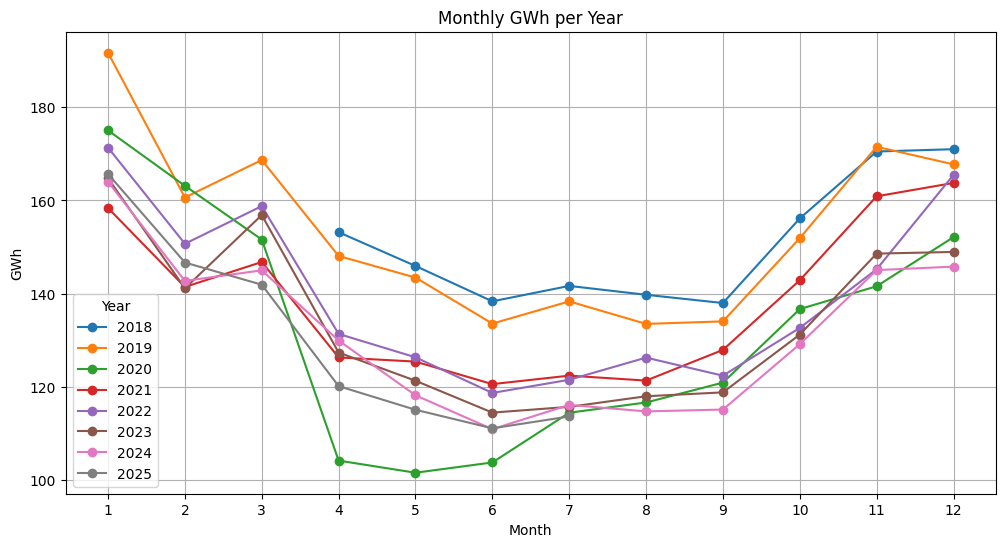

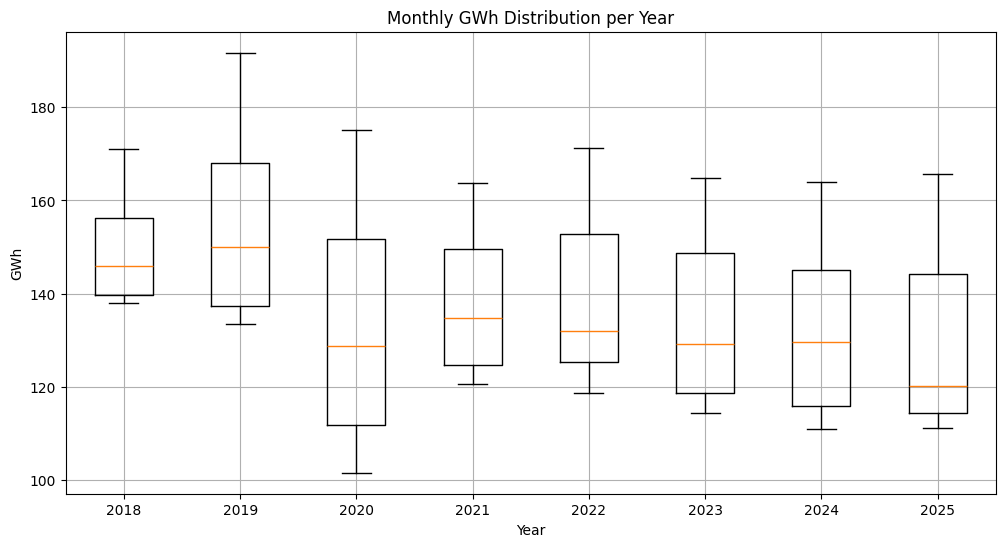

In [42]:
# plot_time_series(df, 'GWh')
graph_monthly(df, 'GWh')
graph_boxplot(df, 'GWh')
# plot_seasonal_decompose(df,'GWh', model='multiplicative', period=12)
# plot_seasonal_decompose(df,'GWh', model='additive', period=12)

##### Exponential Smoothing

In [43]:
# Train/Test split
split_idx = int(len(data) * 0.9)
train, test = data.iloc[:split_idx], data.iloc[split_idx:]

# Grid search
results_df, best_models, train, test = holt_winters_grid_search(data)

# Top forecasts & parameters
future_forecasts, top_params, holt_dates = holt_winters_top_models(results_df, best_models, train, test)

top_params_df = holt_winters_params_table(top_params)


In [44]:
# results_df.sort_values(by="RMSE", ascending=True).head(3)
results_df.sort_values(by="MAPE", ascending=True).head(3)

,Trend,Seasonal,Damped,Seasonal_Periods,RMSE,MAPE
0,mul,mul,True,12.0,3.70,1.83
1,mul,add,True,12.0,3.48,1.95
2,None,mul,False,12.0,4.28,1.99


In [45]:

top_params_df.head()


,smoothing_level,smoothing_trend,smoothing_seasonal,damping_trend
Model,,,,
"('mul', 'mul', True, 12.0)",0.6704,0.0,0.0,0.9684
"('mul', 'add', True, 12.0)",0.6982,0.0,0.0,0.9950
"(None, 'mul', False, 12.0)",0.7230,NaN,0.0,NaN


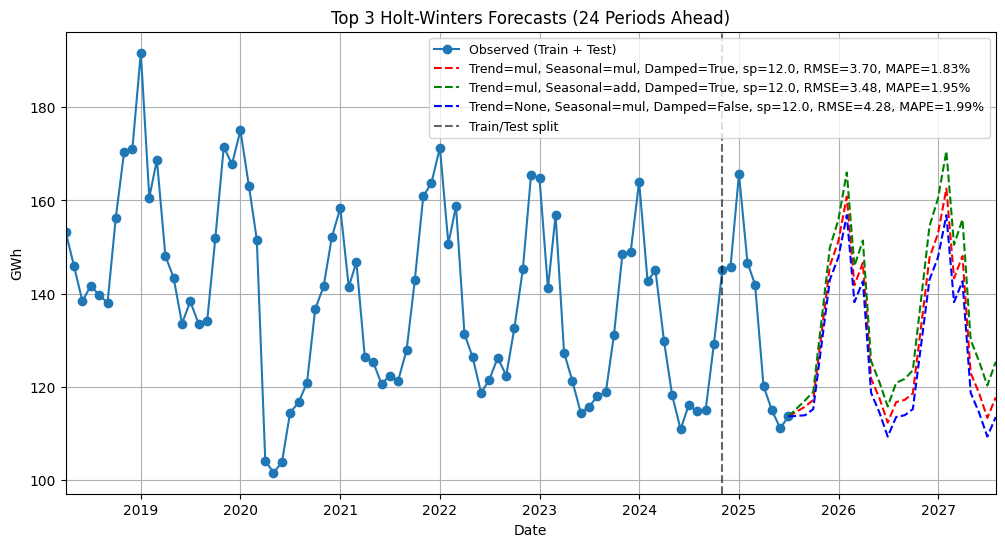

In [46]:
# Plot top 3 forecasts
plot_forecasts(
    data,
    test,
    results_df,
    future_forecasts,
    dates,
    top_n=3,
    y_label="GWh"
)

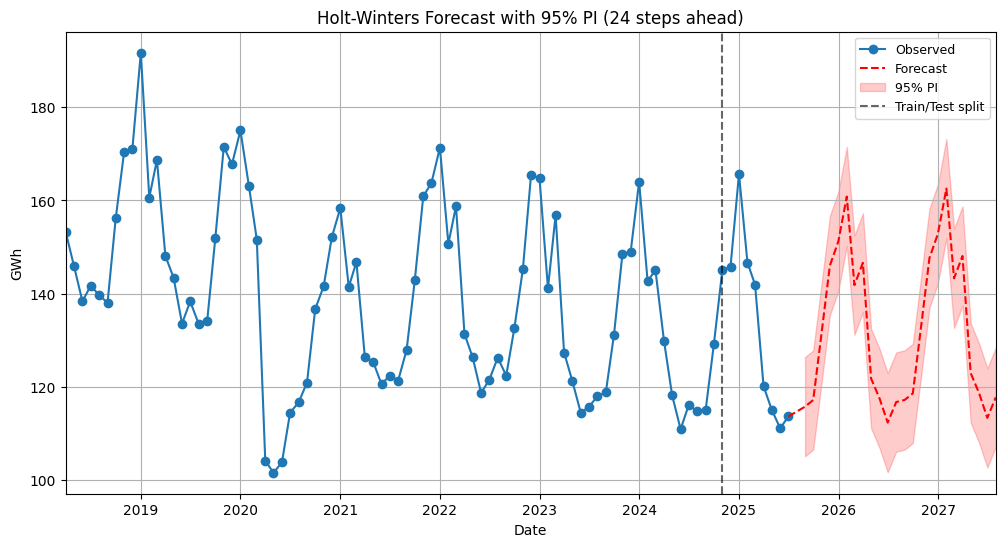

In [47]:
plot_forecast_with_interval(
    data,
    test,
    results_df,
    future_forecasts,
    dates,
    y_label="GWh"
)


This forecast picks up the strong seasonal pattern. Historically, demand rises and falls in a regular cycle each year, with peaks and troughs. The model projects the same seasonal shape into the future. The shaded pink area represents the 95% prediction interval, which is wider further out, showing increasing uncertainty the more we look ahead.

This forecast suggests that the seasonal cycle is expected to continue in a stable way over the next two years, with a general downward trend. 

The model suggests we will expect the same seasonal pattern into 2026 and 2027, but with a smaller peak and trough size.

Be mindful of possible shocks like the COVID-19 in 2020.